In [1]:
# Import Libraries
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Reading the Dataframe
train_df = pd.read_csv("/content/Train.csv")
test_df = pd.read_csv("/content/Test.csv")
val_df = pd.read_csv("/content/Validation.csv")

In [3]:
# set time as index
train_df.set_index('time', inplace=True)
test_df.set_index('time', inplace=True)
val_df.set_index('time', inplace=True)


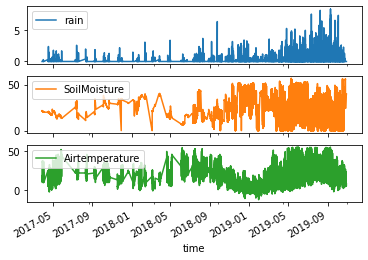

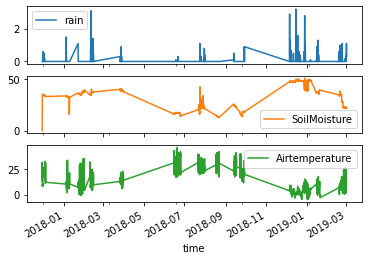

In [7]:
# plot the data - visual inspection
plot_cols = ['rain', 'SoilMoisture', 'Airtemperature']
plot_features = train_df[plot_cols]
date_time = pd.to_datetime(train_df.index, format='%Y-%m-%dT%H:%M:%S')
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = train_df[plot_cols][0:3000]
plot_features.index = date_time[0:3000]
_ = plot_features.plot(subplots=True)

In [8]:
# Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

for x in ['Airtemperature', 'SoilMoisture', 'rain']:
  train_df[x] = (train_df[x] - train_mean[x]) / train_std[x]
  val_df[x] = (val_df[x] - train_mean[x]) / train_std[x]
  test_df[x] = (test_df[x] - train_mean[x]) / train_std[x]


train_df['Longitude'] = train_df['Longitude'] / 180
val_df['Longitude'] = val_df['Longitude'] / 180
test_df['Longitude'] = test_df['Longitude'] / 180

train_df['Latitude'] = train_df['Latitude'] / 90
val_df['Latitude'] = val_df['Latitude'] / 90
test_df['Latitude'] = test_df['Latitude'] / 90

<ipython-input-8-0495644218a9>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_mean = train_df.mean()
<ipython-input-8-0495644218a9>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_std = train_df.std()


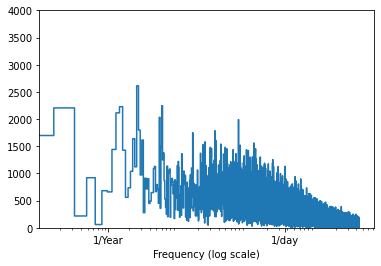

In [9]:
# Use Forier series to find time seasonality
fft = tf.signal.rfft(train_df['rain'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_df['rain'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

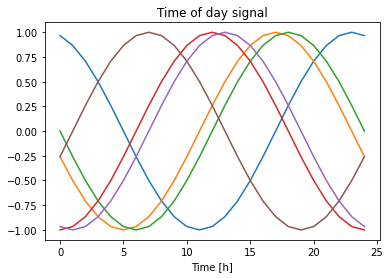

In [10]:
# Converting time into sine and cosine transforms to account for perodicity
for df in [train_df, test_df, val_df]:

  df['Date Time'] = df.index
  date_time = pd.to_datetime(df.pop('Date Time'), format='%Y-%m-%d %H:%M:%S')

  timestamp_s = date_time.map(pd.Timestamp.timestamp)

  day = 24*60*60
  year = (365.2425)*day

  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  plt.plot(np.array(df['Day sin'])[:25])
  plt.plot(np.array(df['Day cos'])[:25])
  plt.xlabel('Time [h]')
  plt.title('Time of day signal')

In [11]:
# check data
test_df

,Serial,Longitude,Latitude,Airtemperature,SoilMoisture,rain,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,
2017-12-06T12:00:00.000Z,PI040298AA3L032108,0.138889,0.444444,-0.414008,0.666786,-0.261728,2.863218e-12,-1.000000,-0.419122,0.907930
2017-12-06T13:00:00.000Z,PI040298AA3L032108,0.138889,0.444444,-0.437906,0.675060,-0.261728,-2.588190e-01,-0.965926,-0.418471,0.908230
2017-12-06T14:00:00.000Z,PI040298AA3L032108,0.138889,0.444444,-0.827483,0.667593,-0.261728,-5.000000e-01,-0.866025,-0.417820,0.908530
2017-12-06T15:00:00.000Z,PI040298AA3L032108,0.138889,0.444444,-1.013434,0.664970,-0.261728,-7.071068e-01,-0.707107,-0.417168,0.908829
2017-12-06T16:00:00.000Z,PI040298AA3L032108,0.138889,0.444444,-1.026378,0.661943,-0.261728,-8.660254e-01,-0.500000,-0.416517,0.909128
...,...,...,...,...,...,...,...,...,...,...
2019-05-18T07:00:00.000Z,PI040307AD5G202386,0.100000,0.500000,0.078875,-0.272703,-0.261728,9.659258e-01,-0.258819,0.701695,-0.712478
2019-05-18T08:00:00.000Z,PI040307AD5G202386,0.100000,0.500000,0.352948,-0.273510,-0.261728,8.660254e-01,-0.500000,0.701184,-0.712980
2019-05-18T09:00:00.000Z,PI040307AD5G202386,0.100000,0.500000,0.406219,-0.278353,-0.261728,7.071068e-01,-0.707107,0.700673,-0.713483


In [12]:
# Class to generate windows of the data by given parameters. 
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
# split_window method will convert them to a window of inputs and a window of labels.
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
# Visualisation
def plot(self, model=None, plot_col='rain', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [16]:
# Making Datasets
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)
    return ds
    
WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



In [18]:
# Function to generate windows from data split by sensor
column_indices = 0
num_features = 0

def generateData(input_width, label_width, shift):
  full_train_ds = []
  full_val_ds = []
  full_test_ds = []
  for serial in train_df['Serial'].unique():
    filtered_train_df = train_df.loc[train_df['Serial'] == serial]
    filtered_val_df = val_df.loc[val_df['Serial'] == serial]
    filtered_test_df = test_df.loc[test_df['Serial'] == serial]
    
    filtered_train_df = filtered_train_df.drop('Serial', axis = 1)
    filtered_val_df = filtered_val_df.drop('Serial', axis = 1)
    filtered_test_df = filtered_test_df.drop('Serial', axis = 1)
    
    global column_indices
    global num_features
    column_indices = {name: i for i, name in enumerate(filtered_train_df.columns)}
    num_features = filtered_train_df.shape[1]


    window = WindowGenerator(
      input_width=input_width, label_width=label_width, shift=shift,
      train_df=filtered_train_df, val_df=filtered_val_df, test_df=filtered_test_df,
      label_columns=['rain'])

    if filtered_train_df.shape[0] > 0:
      full_train_ds.append(window.train)
    if filtered_val_df.shape[0] > 0:
      full_val_ds.append(window.val)
    if filtered_test_df.shape[0] > 0:
      full_test_ds.append(window.test)

  all_train = full_train_ds[0].concatenate(full_train_ds[1])
  all_val = full_val_ds[0].concatenate(full_val_ds[1])
  all_test = full_test_ds[0].concatenate(full_test_ds[1])
  for i in range(2, len(full_train_ds)):
    all_train = all_train.concatenate(full_train_ds[i])
  for i in range(2, len(full_val_ds)):
    all_val = all_val.concatenate(full_val_ds[i])
  for i in range(2, len(full_test_ds)):
    all_test = all_test.concatenate(full_test_ds[i])

  return (all_train, all_val, all_test, window)

In [19]:
# Helper function to define a training regimen
MAX_EPOCHS = 20

def compile_and_fit(model, train, val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=val,
                      callbacks=[early_stopping])
  return history

#PART I: Single Step Models

In [20]:
# Window for single step models
single_step_window = generateData(input_width=48, label_width=48, shift=1)

single_step_window

(<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 Total window size: 49
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
 Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
 Label column name(s): ['rain'])

##Baseline

In [21]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [22]:
baseline = Baseline(label_index=column_indices['rain'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window[1])
performance['Baseline'] = baseline.evaluate(single_step_window[2], verbose=0)

419/419 [==============================] - 5s 8ms/step - loss: 0.5264 - mean_absolute_error: 0.1922


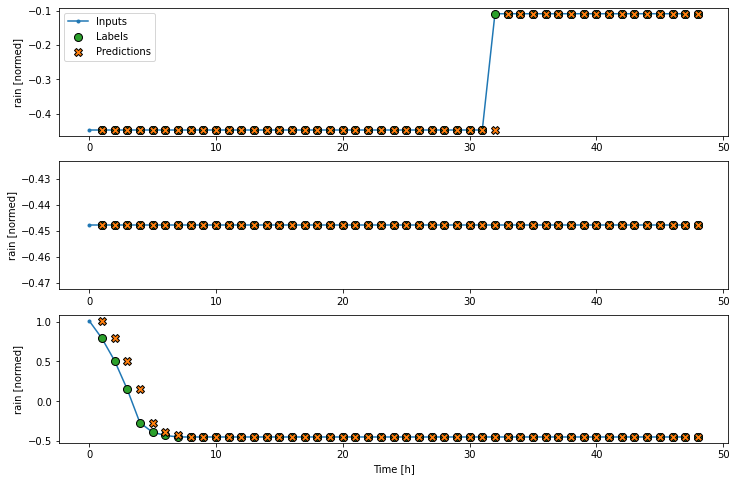

In [ ]:
single_step_window[3].plot(baseline)

##Linear

In [23]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [24]:
history = compile_and_fit(linear, single_step_window[0], single_step_window[1])

val_performance['Linear'] = linear.evaluate(single_step_window[1])
performance['Linear'] = linear.evaluate(single_step_window[2], verbose=0)

Epoch 1/20
1602/1602 [==============================] - 12s 7ms/step - loss: 0.6373 - mean_absolute_error: 0.4264 - val_loss: 0.4728 - val_mean_absolute_error: 0.2306
Epoch 2/20
1602/1602 [==============================] - 9s 6ms/step - loss: 0.4118 - mean_absolute_error: 0.2095 - val_loss: 0.4690 - val_mean_absolute_error: 0.2263
Epoch 3/20
1602/1602 [==============================] - 10s 7ms/step - loss: 0.4109 - mean_absolute_error: 0.2069 - val_loss: 0.4689 - val_mean_absolute_error: 0.2320
Epoch 4/20
1602/1602 [==============================] - 10s 6ms/step - loss: 0.4107 - mean_absolute_error: 0.2077 - val_loss: 0.4690 - val_mean_absolute_error: 0.2347
Epoch 5/20
419/419 [==============================] - 3s 6ms/step - loss: 0.4690 - mean_absolute_error: 0.2346


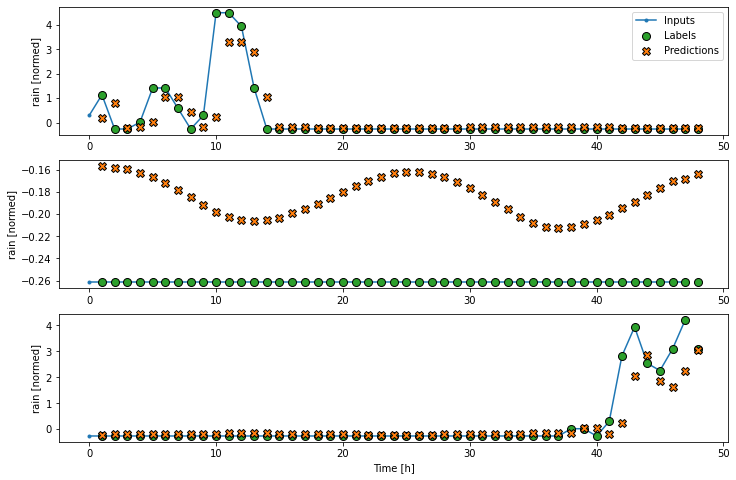

In [25]:
single_step_window[3].plot(linear)

##Convolutional

In [26]:
# Define convolutional window
CONV_WIDTH = 3
conv_window = generateData(input_width=CONV_WIDTH, label_width=1, shift=1)
conv_window

(<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 3, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 3, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 3, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>,
 Total window size: 4
 Input indices: [0 1 2]
 Label indices: [3]
 Label column name(s): ['rain'])

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

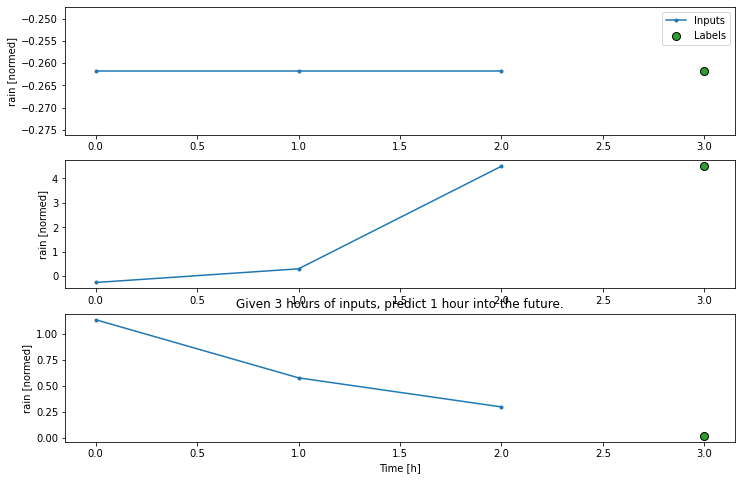

In [27]:
# Check convolutional window
conv_window[3].plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [28]:
#cnn
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [29]:
history = compile_and_fit(conv_model, conv_window[0], conv_window[1])

val_performance['Conv'] = conv_model.evaluate(conv_window[1])
performance['Conv'] = conv_model.evaluate(conv_window[2], verbose=0)

Epoch 1/20
1734/1734 [==============================] - 16s 9ms/step - loss: 0.4425 - mean_absolute_error: 0.2400 - val_loss: 0.4883 - val_mean_absolute_error: 0.2403
Epoch 2/20
1734/1734 [==============================] - 15s 9ms/step - loss: 0.4153 - mean_absolute_error: 0.2195 - val_loss: 0.4873 - val_mean_absolute_error: 0.2492
Epoch 3/20
1734/1734 [==============================] - 11s 6ms/step - loss: 0.4116 - mean_absolute_error: 0.2160 - val_loss: 0.4872 - val_mean_absolute_error: 0.2388
Epoch 4/20
1734/1734 [==============================] - 13s 8ms/step - loss: 0.4103 - mean_absolute_error: 0.2132 - val_loss: 0.4909 - val_mean_absolute_error: 0.2370
Epoch 5/20
538/538 [==============================] - 3s 6ms/step - loss: 0.4893 - mean_absolute_error: 0.2228


In [30]:
# Window for visualising results of CNN
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = generateData(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1)

wide_conv_window

(<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 26, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 26, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 26, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>,
 Total window size: 27
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25]
 Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
 Label column name(s): ['rain'])

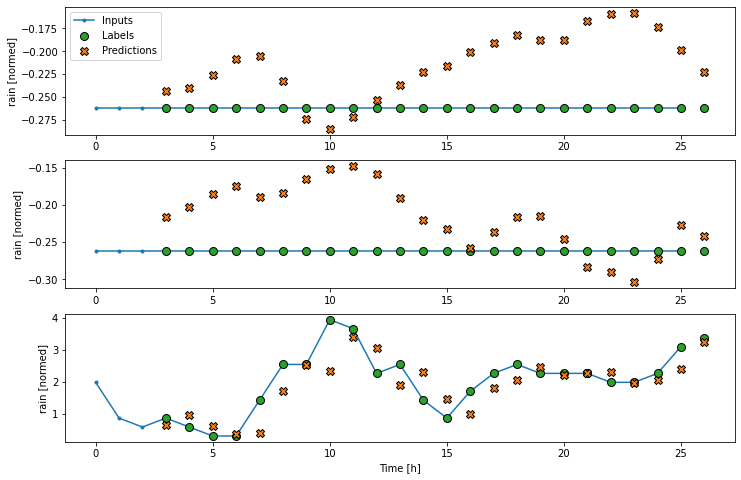

In [31]:
wide_conv_window[3].plot(conv_model)

##Long Short Term Memory

In [32]:
#RNN
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [33]:
history = compile_and_fit(lstm_model, single_step_window[0], single_step_window[1])

val_performance['LSTM'] = lstm_model.evaluate(single_step_window[1])
performance['LSTM'] = lstm_model.evaluate(single_step_window[2], verbose=0)

Epoch 1/20
1602/1602 [==============================] - 34s 20ms/step - loss: 0.4289 - mean_absolute_error: 0.2197 - val_loss: 0.4611 - val_mean_absolute_error: 0.2760
Epoch 2/20
1602/1602 [==============================] - 32s 20ms/step - loss: 0.3952 - mean_absolute_error: 0.2062 - val_loss: 0.4585 - val_mean_absolute_error: 0.2609
Epoch 3/20
1602/1602 [==============================] - 33s 20ms/step - loss: 0.3843 - mean_absolute_error: 0.2025 - val_loss: 0.4641 - val_mean_absolute_error: 0.2674
Epoch 4/20
419/419 [==============================] - 4s 10ms/step - loss: 0.4650 - mean_absolute_error: 0.2717


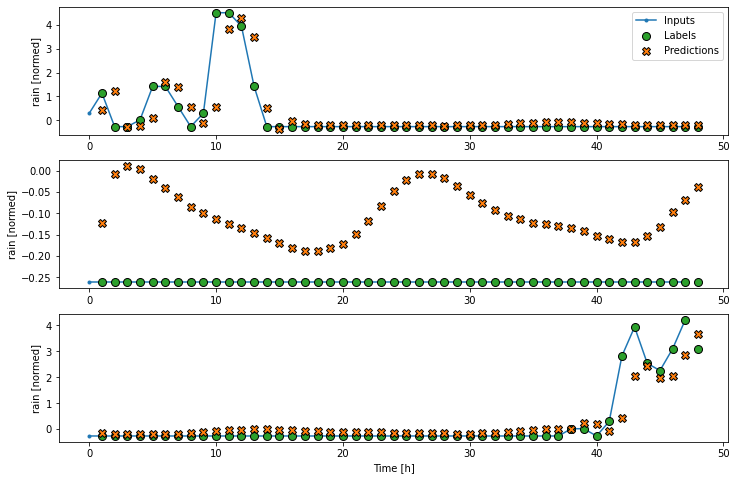

In [34]:
single_step_window[3].plot(lstm_model)

##Visualise all single step model results

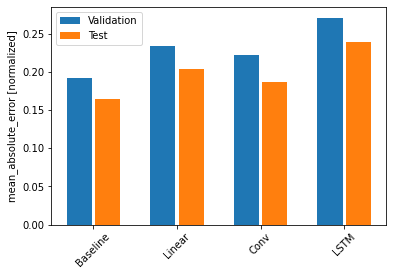

In [35]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

#PART II: Multistep Models

(<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 24, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 24, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>,
 <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 24, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>,
 Total window size: 48
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
 Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
 Label column name(s): ['rain'])

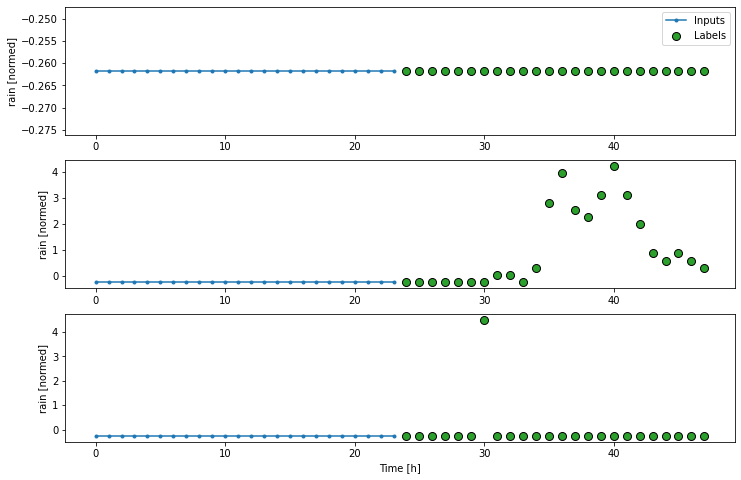

In [36]:
# define window for multi step model
OUT_STEPS = 24
multi_window = generateData(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window[3].plot()
multi_window

##Multistep baseline

422/422 [==============================] - 4s 6ms/step - loss: 1.7422 - mean_absolute_error: 0.7959


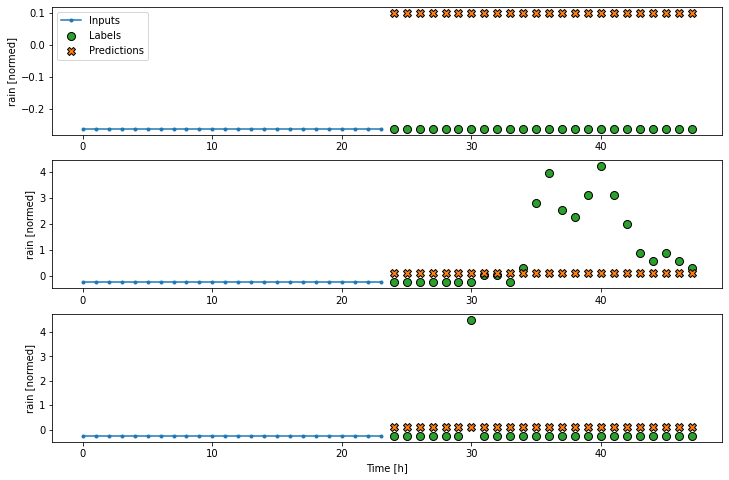

In [37]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window[1])
multi_performance['Last'] = last_baseline.evaluate(multi_window[2], verbose=0)
multi_window[3].plot(last_baseline)

##Multistep Linear

Epoch 1/20
1605/1605 [==============================] - 11s 6ms/step - loss: 0.9468 - mean_absolute_error: 0.4123 - val_loss: 1.0868 - val_mean_absolute_error: 0.4561
Epoch 2/20
1605/1605 [==============================] - 10s 6ms/step - loss: 0.9339 - mean_absolute_error: 0.4059 - val_loss: 1.0846 - val_mean_absolute_error: 0.4539
Epoch 3/20
1605/1605 [==============================] - 10s 6ms/step - loss: 0.9335 - mean_absolute_error: 0.4049 - val_loss: 1.0842 - val_mean_absolute_error: 0.4548
Epoch 4/20
1605/1605 [==============================] - 10s 6ms/step - loss: 0.9335 - mean_absolute_error: 0.4056 - val_loss: 1.0842 - val_mean_absolute_error: 0.4551
Epoch 5/20
422/422 [==============================] - 3s 8ms/step - loss: 1.0845 - mean_absolute_error: 0.4513


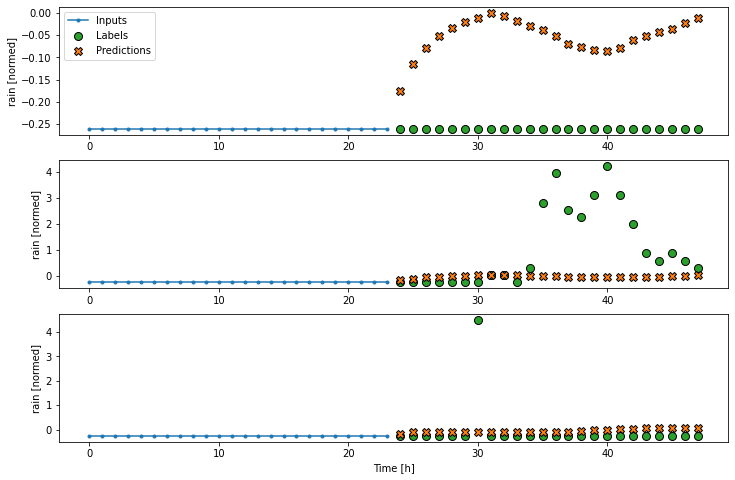

In [38]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window[0], multi_window[1])

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window[1])
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window[2], verbose=0)
multi_window[3].plot(multi_linear_model)

##Multistep Dense

Epoch 1/20
1605/1605 [==============================] - 16s 10ms/step - loss: 0.9261 - mean_absolute_error: 0.3973 - val_loss: 1.0776 - val_mean_absolute_error: 0.4587
Epoch 2/20
1605/1605 [==============================] - 14s 9ms/step - loss: 0.9164 - mean_absolute_error: 0.3950 - val_loss: 1.0786 - val_mean_absolute_error: 0.4717
Epoch 3/20
1605/1605 [==============================] - 12s 7ms/step - loss: 0.9137 - mean_absolute_error: 0.3961 - val_loss: 1.0762 - val_mean_absolute_error: 0.4683
Epoch 4/20
1605/1605 [==============================] - 14s 9ms/step - loss: 0.9129 - mean_absolute_error: 0.3947 - val_loss: 1.0759 - val_mean_absolute_error: 0.4595
Epoch 5/20
1605/1605 [==============================] - 14s 9ms/step - loss: 0.9110 - mean_absolute_error: 0.3940 - val_loss: 1.0772 - val_mean_absolute_error: 0.4570
Epoch 6/20
422/422 [==============================] - 3s 7ms/step - loss: 1.0788 - mean_absolute_error: 0.4637


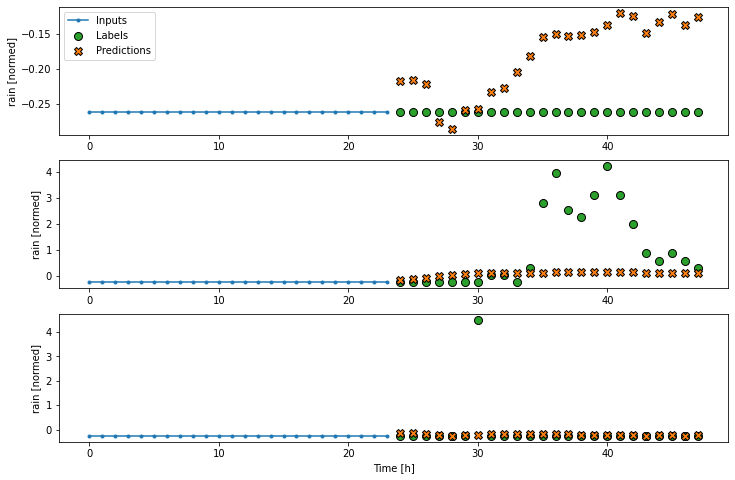

In [39]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window[0], multi_window[1])

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window[1])
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window[2], verbose=0)
multi_window[3].plot(multi_dense_model)

##Multistep Convolutional

Epoch 1/20
1605/1605 [==============================] - 12s 7ms/step - loss: 0.9246 - mean_absolute_error: 0.3966 - val_loss: 1.0778 - val_mean_absolute_error: 0.4584
Epoch 2/20
1605/1605 [==============================] - 14s 8ms/step - loss: 0.9153 - mean_absolute_error: 0.3957 - val_loss: 1.0782 - val_mean_absolute_error: 0.4621
Epoch 3/20
1605/1605 [==============================] - 14s 8ms/step - loss: 0.9112 - mean_absolute_error: 0.3950 - val_loss: 1.0751 - val_mean_absolute_error: 0.4448
Epoch 4/20
1605/1605 [==============================] - 11s 7ms/step - loss: 0.9096 - mean_absolute_error: 0.3944 - val_loss: 1.0730 - val_mean_absolute_error: 0.4625
Epoch 5/20
1605/1605 [==============================] - 12s 7ms/step - loss: 0.9092 - mean_absolute_error: 0.3952 - val_loss: 1.0760 - val_mean_absolute_error: 0.4521
Epoch 6/20
422/422 [==============================] - 3s 7ms/step - loss: 1.0779 - mean_absolute_error: 0.4613


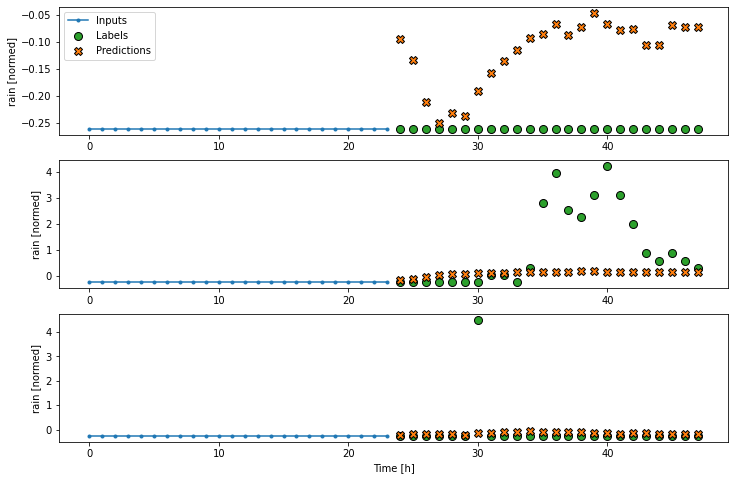

In [40]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window[0], multi_window[1])

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window[1])
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window[2], verbose=0)
multi_window[3].plot(multi_conv_model)

##Multistep LSTM

Epoch 1/20
1605/1605 [==============================] - 24s 14ms/step - loss: 0.9256 - mean_absolute_error: 0.3935 - val_loss: 1.0715 - val_mean_absolute_error: 0.4391
Epoch 2/20
1605/1605 [==============================] - 21s 13ms/step - loss: 0.9132 - mean_absolute_error: 0.3884 - val_loss: 1.0710 - val_mean_absolute_error: 0.4410
Epoch 3/20
1605/1605 [==============================] - 21s 13ms/step - loss: 0.9117 - mean_absolute_error: 0.3913 - val_loss: 1.0693 - val_mean_absolute_error: 0.4321
Epoch 4/20
1605/1605 [==============================] - 22s 14ms/step - loss: 0.9060 - mean_absolute_error: 0.3861 - val_loss: 1.0681 - val_mean_absolute_error: 0.4361
Epoch 5/20
1605/1605 [==============================] - 21s 13ms/step - loss: 0.8928 - mean_absolute_error: 0.3826 - val_loss: 1.0698 - val_mean_absolute_error: 0.4303
Epoch 6/20
422/422 [==============================] - 3s 8ms/step - loss: 1.0712 - mean_absolute_error: 0.4303


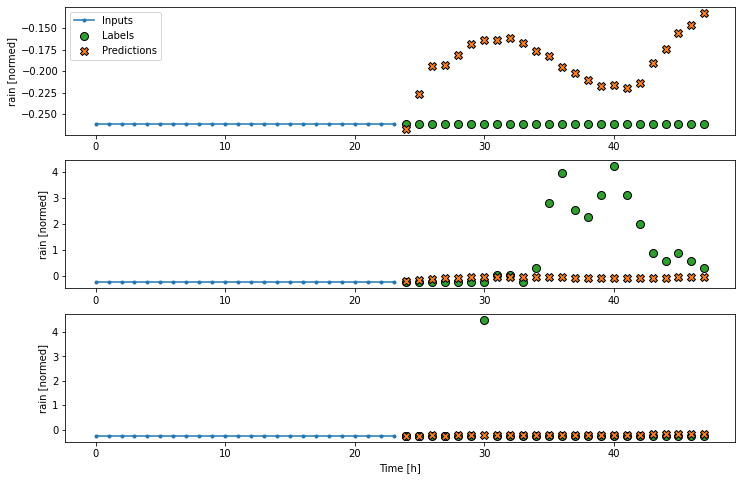

In [41]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window[0], multi_window[1])

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window[1])
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window[2], verbose=0)
multi_window[3].plot(multi_lstm_model)

##Results for multistep models

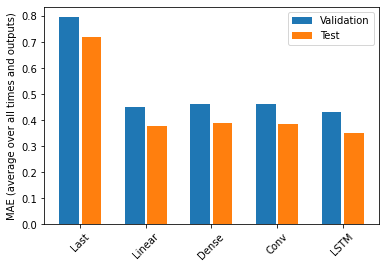

In [42]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [43]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.7216
Linear  : 0.3767
Dense   : 0.3891
Conv    : 0.3870
LSTM    : 0.3526
